## Importing the libraries



In [1]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
#import imageio
from PIL import Image, ImageOps
import cv2
from torchvision.models import vgg16_bn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.utils import make_grid
from albumentations.pytorch import ToTensorV2
import albumentations as A
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
torch.__version__

'2.1.0+cu118'

## Configuration for setting device, batch size and learning rate.

In [4]:
config = {'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
         'batch_size': 2,
         'learning_rate': 0.001,
         }

# Extracting configurations from dictionary
device=config['device']
batch_size=config['batch_size']
lr=config['learning_rate']

## Visualizing dataset

In [5]:
# Defining root directory.
root = "/content/drive/My Drive/Assignment3/Cam101"

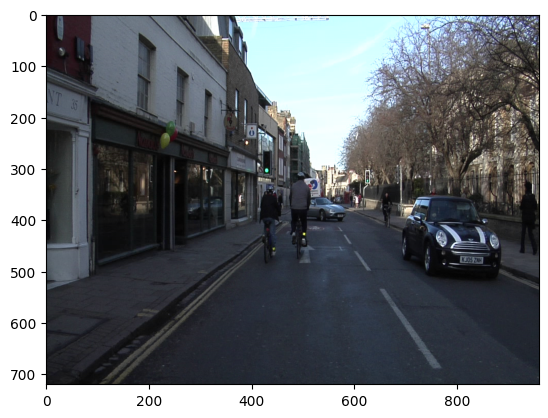

In [6]:
# Reading and plotting the image.
img = cv2.imread(os.path.join(root, "train")+'/0016E5_07961.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img.transpose(0,1,2))

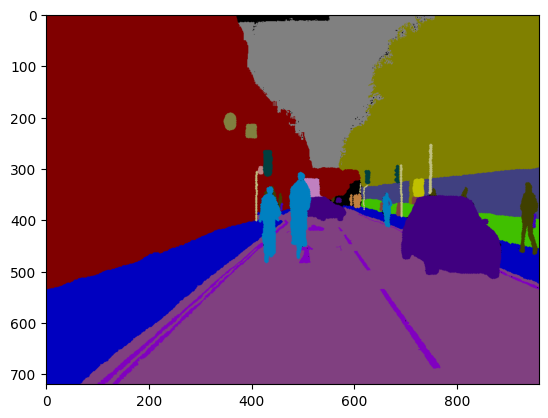

In [7]:
# Reading and plotting the mask image.
img = cv2.imread(os.path.join(root, "train")+'/0016E5_07961_L.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img.transpose(0,1,2))

In [8]:
# Finding unique pixel values from mask image.
np.unique(img)

array([  0,  64, 128, 192], dtype=uint8)

## Reading color codes from a file and storing them in a dictionary.

In [9]:
color_codes = OrderedDict()
with open(os.path.join(root, "label_colors.txt"), 'r') as f:
    line = f.readline()
    while line:
        line = f.readline()
        l = line.strip().split()
        try:
            color_codes[l[-1]] = [int(i) for i in l[:-1]]
        except:
            pass
color_codes

OrderedDict([('Archway', [192, 0, 128]),
             ('Bicyclist', [0, 128, 192]),
             ('Bridge', [0, 128, 64]),
             ('Building', [128, 0, 0]),
             ('Car', [64, 0, 128]),
             ('CartLuggagePram', [64, 0, 192]),
             ('Child', [192, 128, 64]),
             ('Column_Pole', [192, 192, 128]),
             ('Fence', [64, 64, 128]),
             ('LaneMkgsDriv', [128, 0, 192]),
             ('LaneMkgsNonDriv', [192, 0, 64]),
             ('Misc_Text', [128, 128, 64]),
             ('MotorcycleScooter', [192, 0, 192]),
             ('OtherMoving', [128, 64, 64]),
             ('ParkingBlock', [64, 192, 128]),
             ('Pedestrian', [64, 64, 0]),
             ('Road', [128, 64, 128]),
             ('RoadShoulder', [128, 128, 192]),
             ('Sidewalk', [0, 0, 192]),
             ('SignSymbol', [192, 128, 128]),
             ('Sky', [128, 128, 128]),
             ('SUVPickupTruck', [64, 128, 192]),
             ('TrafficCone', [0, 0, 64]),
 

In [10]:
# Finding the length of dictionary.
len(color_codes)

31

## UDF to plot loss graphs

In [11]:
def plot_loss_accuracy(train_losses, train_accs,val_losses, val_accs, model_name):
    """
    Plot the training and validation loss and accuracy over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        train_accs (list): List of training accuracies for each epoch.
        val_accs (list): List of validation accuracies for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title(model_name + 'Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r', label='Validation Accuracy')
    plt.title(model_name + 'Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Defining a custom dataset class.

In [12]:
class CamSeqDataset(Dataset):

    def __init__(self,
                 img_dir,
                 color_codes=color_codes,
                 transforms=None):
        # Initialize the superclass
        super().__init__()
        # Creating lists of image and mask files.
        self.images = sorted([os.path.join(
            img_dir, x) for x in os.listdir(img_dir)
                      if not x.split('.')[0].endswith('_L')])
        # Filter out any text files
        self.images = [x for x in self.images if not x.endswith('.txt')]
        # Get a list of paths to all the masks in the directory
        self.masks = sorted([os.path.join(
            img_dir, x) for x in os.listdir(img_dir)
                     if x.split('.')[0].endswith('_L')])
        # Storing color codes and number of classes.
        self.color_codes = color_codes
        self.num_classes = len(self.color_codes)

        # Save the data augmentation transforms
        self.transforms = transforms

    def __len__(self):
      # Return the number of images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Opening and converting image and mask to RGB format.
        img = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        # Convert the image and mask to RGB format if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')
        if mask.mode != 'RGB':
            mask = mask.convert('RGB')
        # Converting images to numpy arrays.
        img = np.asarray(img)
        mask = np.asarray(mask)
        # Create a separate mask for each class using the color codes
        mask_channels = np.zeros(
            (mask.shape[0], mask.shape[1]), dtype=np.int64)
        # Assigning unique label to each pixel using its color code.
        for i, cls in enumerate(self.color_codes.keys()):
            color = self.color_codes[cls]
            sub_mask = np.all(mask==color, axis=-1)*i
            mask_channels += sub_mask #*i
        # Apply the data augmentation transforms
        if self.transforms is not None:
            transformed = self.transforms(image=img, masks=mask_channels)
            img = transformed['image']
            mask_channels = transformed['masks']
        # Convert the image and mask to PyTorch tensors
        mask_channels = mask_channels.astype(np.float32)
        img = img.astype(np.float32) #/255

        instance = {'image': torch.from_numpy(img.transpose(2,0,1)),
                    'mask': torch.from_numpy(mask_channels)}

        return instance

## Define a double convolutional layer for UNET

In [13]:
def double_convolution(in_channels, out_channels):
    # Define the convolutional operation as a sequential module
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        # Define a max pooling layer
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        # Contracting path.
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        # output mask.
        out = self.out(x)
        return out

In [14]:
# Define the loss function and the optimizer in Train function.
def train_model(model,
                train_loader,
                val_loader,
                criterion= nn.CrossEntropyLoss(),
                num_epochs=1,
                device=device):

    model.to(device)
    # Set the model to training mode.
    model.train()
    # Define the optimizer.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tr_avg_loss = []
    tr_avg_acc = []
    val_avg_loss = []
    val_avg_acc = []
    # Train the model.
    for epoch in range(1, num_epochs + 1):
        # Define lists to store the training and validation losses for each epoch.
        tr_loss = []
        val_loss = []
        tr_correct = 0
        val_correct = 0
        tr_total = 0
        val_total = 0
        print('Epoch {}/{}'.format(epoch, num_epochs))
        # Iterate over the training data in batches.
        for sample in tqdm(train_loader):
            # If there is only one sample, skip the iteration.
            if sample['image'].shape[0]==1:
                break
            # Move the inputs and masks to the specified device.
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)

            # Reset the gradients to zero.
            optimizer.zero_grad()
            # Forward pass through the model
            outputs = model(inputs)
            # Get the predicted outputs.
            try:
              y_pred = outputs['out']
            except:
              y_pred = outputs
            # Get the true outputs.
            y_true = masks
            # Calculate the loss.
            loss = criterion(y_pred.float(), y_true.long())
            # Backward pass through the model to calculate the gradients.
            loss.backward()
            # Store the training loss for this batch.
            tr_loss.append(loss)
            # Update the weights of the model using the optimizer.
            optimizer.step()
            _, predicted = y_pred.max(1)
            _, counts = np.unique(predicted.eq(y_true).cpu().numpy(), return_counts=True)
            # Calculate Accuracy
            tr_total += counts.sum()
            tr_correct += predicted.eq(y_true).sum().item()


        # Calculate the average training loss for this epoch.
        train_loss = torch.mean(torch.Tensor(tr_loss))
        train_accuracy = tr_correct / tr_total
        tr_avg_loss.append(train_loss.item())
        tr_avg_acc.append(train_accuracy)

        # Print the average training loss and accuracy for this epoch.
        print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')


        # Iterate over the validation data in batches.
        for sample in tqdm(val_loader):
            # If there is only one sample, skip the iteration.
            if sample['image'].shape[0]==1:
                break
            # Move the inputs and masks to the specified device.
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)

            # Turn off gradient calculation for validation data.
            with torch.no_grad():
                # Forward pass through the model.
                outputs = model(inputs)
            # Get the predicted outputs.
            try:
              y_pred = outputs['out']
            except:
              y_pred = outputs
            # Get the true outputs.
            y_true = masks
            # Calculate the loss.
            loss = criterion(y_pred.float(), y_true.long())
            # Store the validation loss for this batch.
            val_loss.append(loss)
            # Update the weights of the model using the optimizer.
            optimizer.step()
            # Calculate the accuracy.
            _, predicted = y_pred.max(1)
            _, counts = np.unique(predicted.eq(y_true).cpu().numpy(), return_counts=True)
            val_total += counts.sum()
            val_correct += (predicted == y_true).sum().item()


        # Print the average validation loss and accuracy for this epoch.
        val_loss_avg =  torch.mean(torch.Tensor(val_loss))
        val_accuracy = val_correct / val_total
        val_avg_loss.append(val_accuracy.item())
        val_avg_acc.append(val_accuracy)
        print(f'Validation loss: {val_loss_avg:.4f}, Validation accuracy: {val_accuracy:.4f}')


    return model, tr_avg_loss, tr_avg_acc, val_avg_loss, val_avg_acc

## Create the dataset and dataloader.

In [15]:
dataset = CamSeqDataset(img_dir=os.path.join(root, "train"))
train_size = int(len(dataset)*0.9)
train_set, val_set = random_split(dataset, [train_size, len(dataset)-train_size])
# Define data loaders to load the dataset in batches for efficient processing.
# Here, train_loader and val_loader are created from train_set and val_set, respectively, and the batch size is specified.
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)

In [16]:
def fcn(num_classes = 32):
    model = models.segmentation.fcn_resnet50(pretrained=True)
    filters_of_last_layer = model.classifier[4].in_channels
    filters_of_last_layer_aux = model.aux_classifier[4].in_channels
    model.classifier[4] = nn.Conv2d(filters_of_last_layer,num_classes,kernel_size=(1,1),stride=(1,1))
    model.aux_classifier[4] = nn.Conv2d(filters_of_last_layer_aux,num_classes, kernel_size=(1,1),stride=(1,1))
    # in_features = model.classifier.conv[0].in_channels
    # num_anchors = model.classifier.num_anchors
    # model.classifier.num_classes = num_classes
    # out_channels = num_classes

    # cls_logits = torch.nn.Conv2d(out_channels, num_anchors * num_classes, kernel_size = 3, stride=1, padding=1)
    # torch.nn.init.normal_(cls_logits.weight, std=0.01)
    # torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))

    # model.head.classification_head.cls_logits = cls_logits
    return model

In [17]:
model_fcn = fcn()
# Train the UNet model for 10 epochs using the train_loader and val_loader datasets.
model, tr_avg_loss, tr_avg_acc, val_avg_loss, val_avg_acc= train_model(model=model_fcn,
                                                                       train_loader=train_loader,
                                                                       val_loader=val_loader,
                                                                       num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 79.6MB/s]


Epoch 1/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.8131, Train accuracy: 0.8245


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.4104, Validation accuracy: 0.8939
Epoch 2/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.3603, Train accuracy: 0.8980


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.3494, Validation accuracy: 0.9054
Epoch 3/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.3379, Train accuracy: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.2652, Validation accuracy: 0.9202
Epoch 4/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.2559, Train accuracy: 0.9229


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.2156, Validation accuracy: 0.9320
Epoch 5/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1947, Train accuracy: 0.9382


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1832, Validation accuracy: 0.9420
Epoch 6/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1582, Train accuracy: 0.9474


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1668, Validation accuracy: 0.9456
Epoch 7/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1379, Train accuracy: 0.9526


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1517, Validation accuracy: 0.9497
Epoch 8/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1220, Train accuracy: 0.9571


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1460, Validation accuracy: 0.9524
Epoch 9/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1118, Train accuracy: 0.9601


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1439, Validation accuracy: 0.9539
Epoch 10/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1071, Train accuracy: 0.9613


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1413, Validation accuracy: 0.9545


In [18]:
# Create an instance of the UNet model
model = UNet(32)
# Train the UNet model for 10 epochs using the train_loader and val_loader datasets.
model, tr_avg_loss, tr_avg_acc, val_avg_loss, val_avg_acc= train_model(model=model,
                                                                       train_loader=train_loader,
                                                                       val_loader=val_loader,
                                                                       num_epochs=10)

Epoch 1/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 2.2668, Train accuracy: 0.2882


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 2.2498, Validation accuracy: 0.2778
Epoch 2/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 2.0847, Train accuracy: 0.3571


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 64.3790, Validation accuracy: 0.3851
Epoch 3/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 37.0923, Train accuracy: 0.2083


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 2.2040, Validation accuracy: 0.2542
Epoch 4/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 1.9265, Train accuracy: 0.4010


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.6220, Validation accuracy: 0.5171
Epoch 5/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 1.6757, Train accuracy: 0.4803


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 2.2432, Validation accuracy: 0.4609
Epoch 6/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 2.4478, Train accuracy: 0.3747


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.7373, Validation accuracy: 0.5041
Epoch 7/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 1.6011, Train accuracy: 0.5482


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.3906, Validation accuracy: 0.6149
Epoch 8/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 1.4496, Train accuracy: 0.5682


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.3125, Validation accuracy: 0.5954
Epoch 9/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 1.2780, Train accuracy: 0.6234


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.2624, Validation accuracy: 0.6429
Epoch 10/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 1.3877, Train accuracy: 0.5967


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.4704, Validation accuracy: 0.5217


## Plot loss VS epoch graph

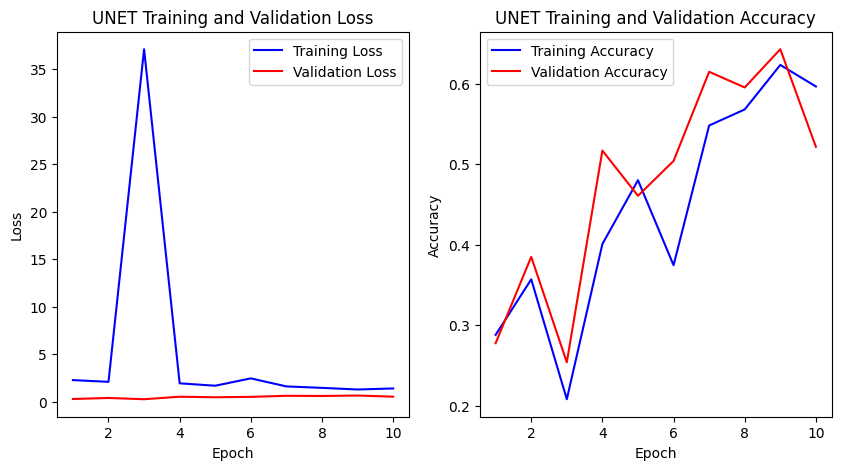

In [19]:
plot_loss_accuracy(tr_avg_loss, tr_avg_acc, val_avg_loss, val_avg_acc, "UNET ")

## Testing the model on test dataset

In [20]:
# Switch the model to evaluation mode
model.eval()
# Create a dataset object for the test data
dataset = CamSeqDataset(img_dir=os.path.join(root, "test"))
# Create a data loader for the test data
test_loader = DataLoader(dataset, batch_size=batch_size)
# Get the predicted masks for one batch of test data
for img in test_loader:
    try:
      image = model(img['image'].to(device))['out']
    except:
      image = model(img['image'].to(device))
    break

## Visualise Test data and predicted results

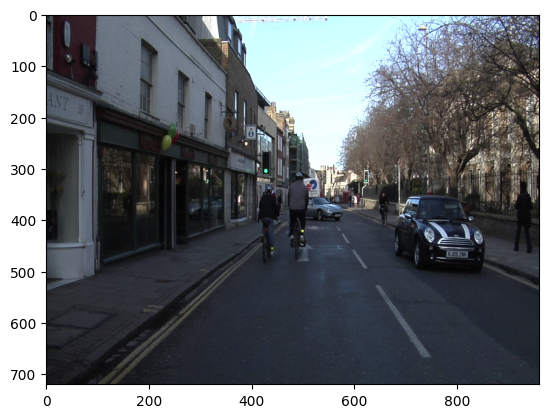

In [21]:
# Display the original image from the test data
plt.imshow(img['image'][0].cpu().permute(1,2,0).numpy().astype(np.uint8))

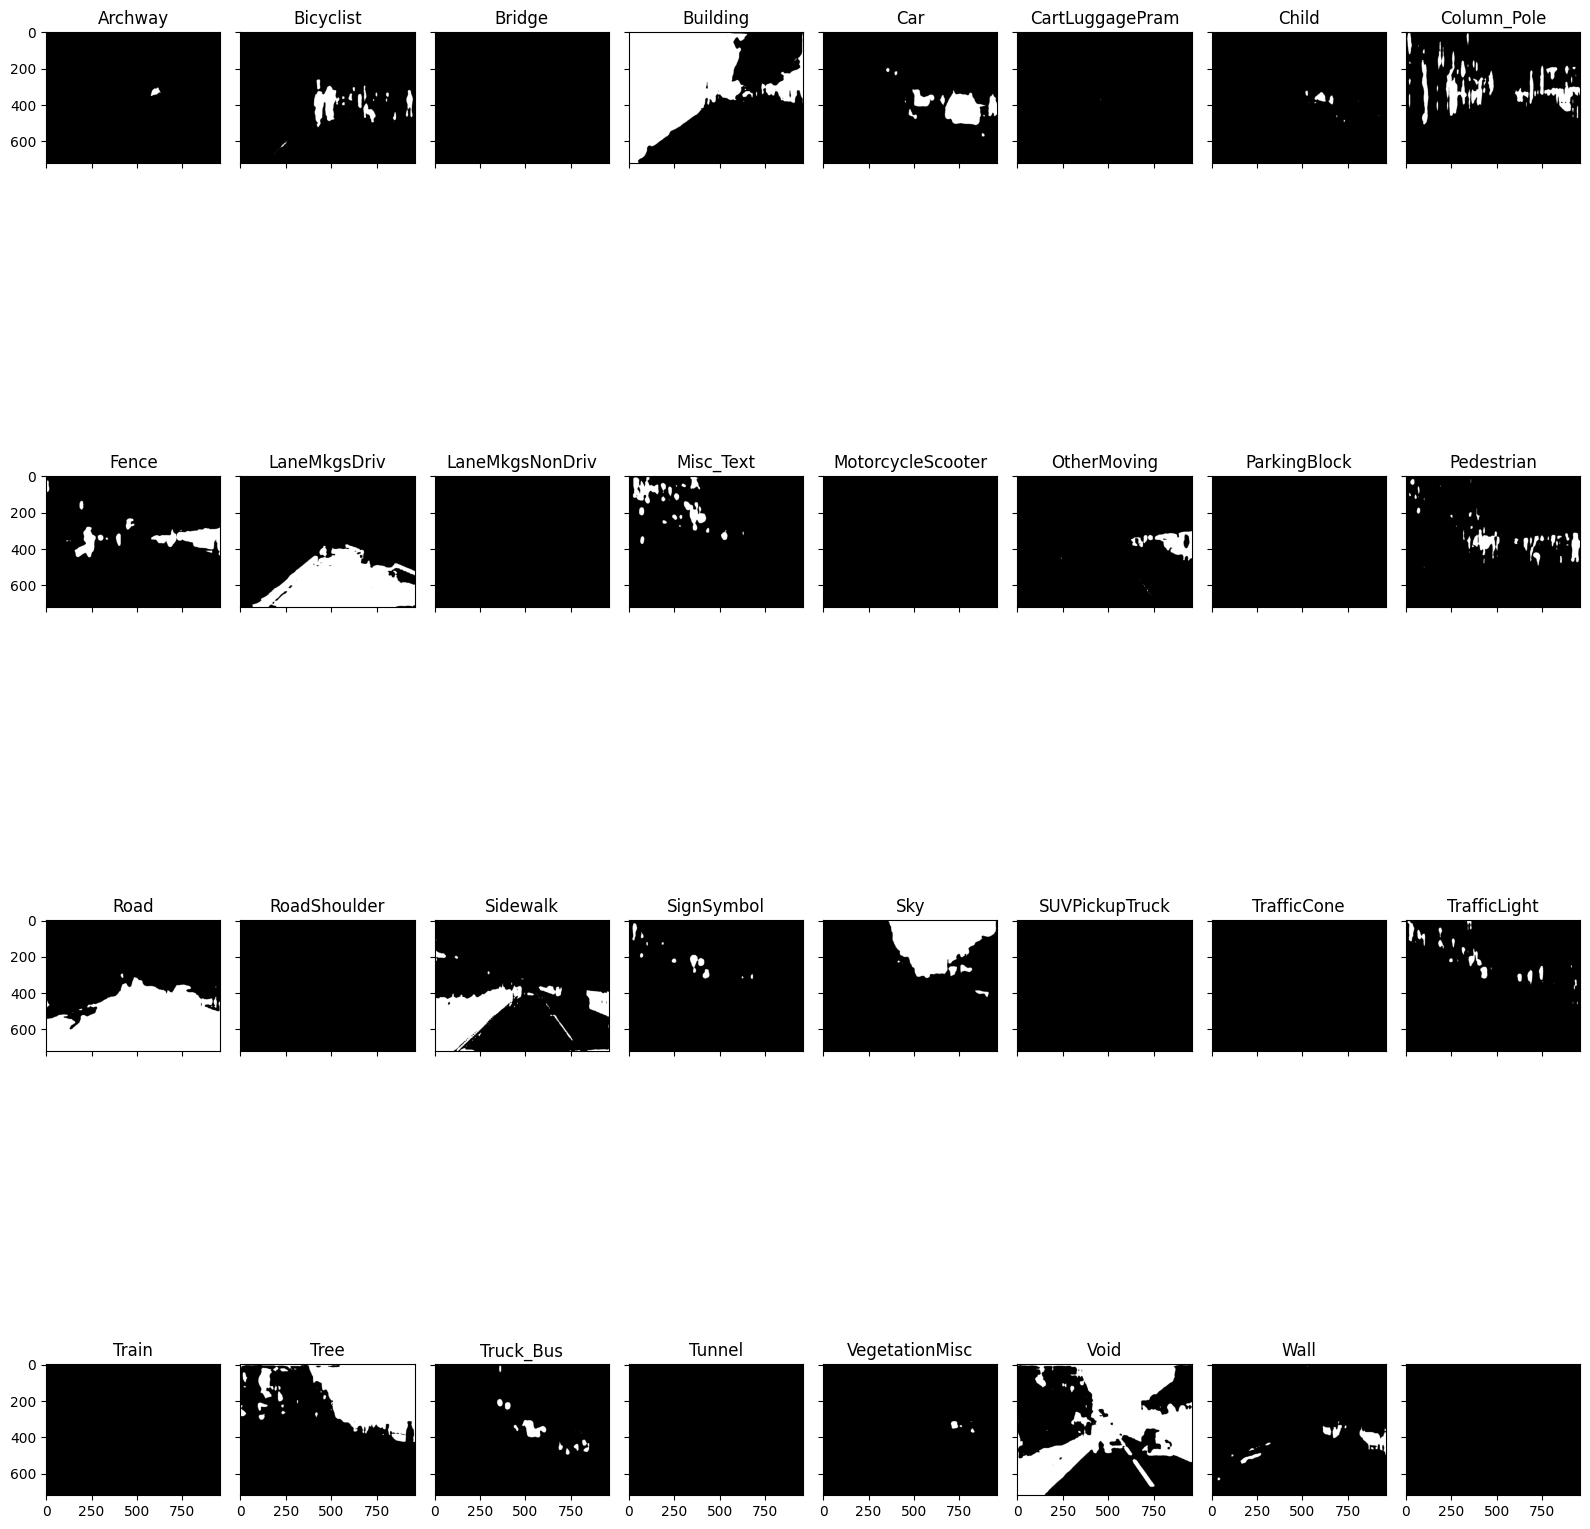

In [37]:
# Create a plot with subplots for each class
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(16,20))
axes_list = [item for sublist in axes for item in sublist]
# Set the threshold for the predicted masks
thresh=0.3
# Get the predicted masks and plot them
res = image[0].detach().cpu().numpy()
for i, mask in enumerate(res):
    ax = axes_list.pop(0)
    ax.imshow(np.where(mask>thresh, 255, 0), cmap='gray')
    try:
      ax.set_title(list(color_codes.keys())[i])
    except:
      break

# Remove any unused subplots and adjust the layout
for ax in axes_list:
    ax.remove()

plt.tight_layout()

## Define DeepLab

In [24]:
def make_deeplab(out_channels=32):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier = models.segmentation.deeplabv3.DeepLabHead(
        2048, num_classes=out_channels)
    return model

In [25]:
# Create an instance of the DeepLab model
model_deep = make_deeplab()
# Train the UNet model for 10 epochs using the train_loader and val_loader datasets.
model_deep, tr_loss_deep, tr_acc_deep, val_loss_deep, val_acc_deep =train_model(model=model_deep,
                                                                                train_loader=train_loader,
                                                                                val_loader=val_loader,
                                                                                num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 77.2MB/s]


Epoch 1/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.6698, Train accuracy: 0.8477


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.3430, Validation accuracy: 0.9075
Epoch 2/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.2805, Train accuracy: 0.9178


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.2190, Validation accuracy: 0.9340
Epoch 3/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1931, Train accuracy: 0.9404


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1784, Validation accuracy: 0.9444
Epoch 4/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1555, Train accuracy: 0.9485


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1670, Validation accuracy: 0.9466
Epoch 5/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1383, Train accuracy: 0.9527


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1566, Validation accuracy: 0.9496
Epoch 6/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1275, Train accuracy: 0.9556


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1446, Validation accuracy: 0.9527
Epoch 7/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1124, Train accuracy: 0.9599


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1431, Validation accuracy: 0.9535
Epoch 8/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1143, Train accuracy: 0.9588


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1412, Validation accuracy: 0.9551
Epoch 9/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1053, Train accuracy: 0.9616


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1439, Validation accuracy: 0.9545
Epoch 10/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1002, Train accuracy: 0.9633


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.1416, Validation accuracy: 0.9555


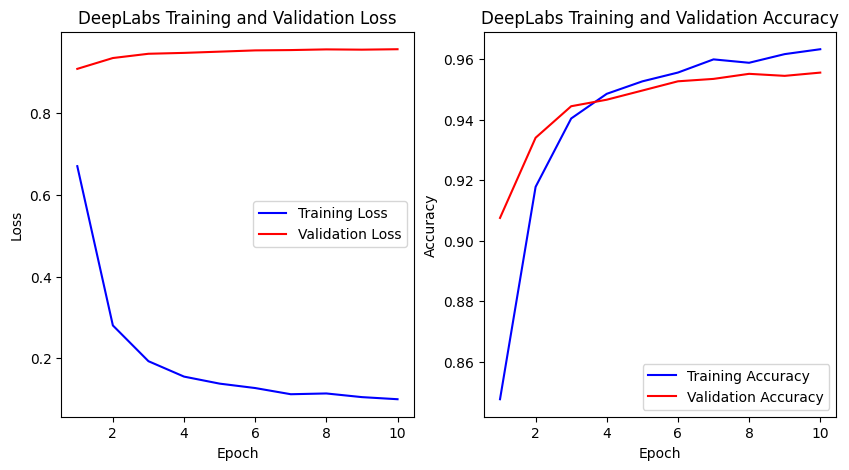

In [26]:
plot_loss_accuracy(tr_loss_deep, tr_acc_deep, val_loss_deep, val_acc_deep, "DeepLabs ")

In [30]:
# Switch the model to evaluation mode
model_deep.eval()
# Create a dataset object for the test data
dataset = CamSeqDataset(img_dir=os.path.join(root, "test"))
# Create a data loader for the test data
test_loader = DataLoader(dataset, batch_size=batch_size)
# Get the predicted masks for one batch of test data
for img in test_loader:
    try:
      image = model_deep(img['image'].to(device))['out']
    except:
      image = model_deep(img['image'].to(device))
    break

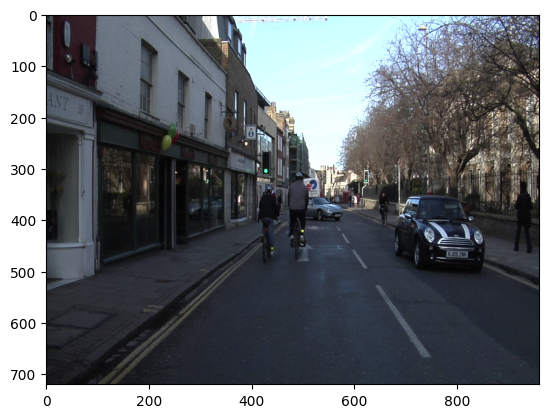

In [31]:
# Display the original image from the test data
plt.imshow(img['image'][0].cpu().permute(1,2,0).numpy().astype(np.uint8))

In [35]:
len(res)

32

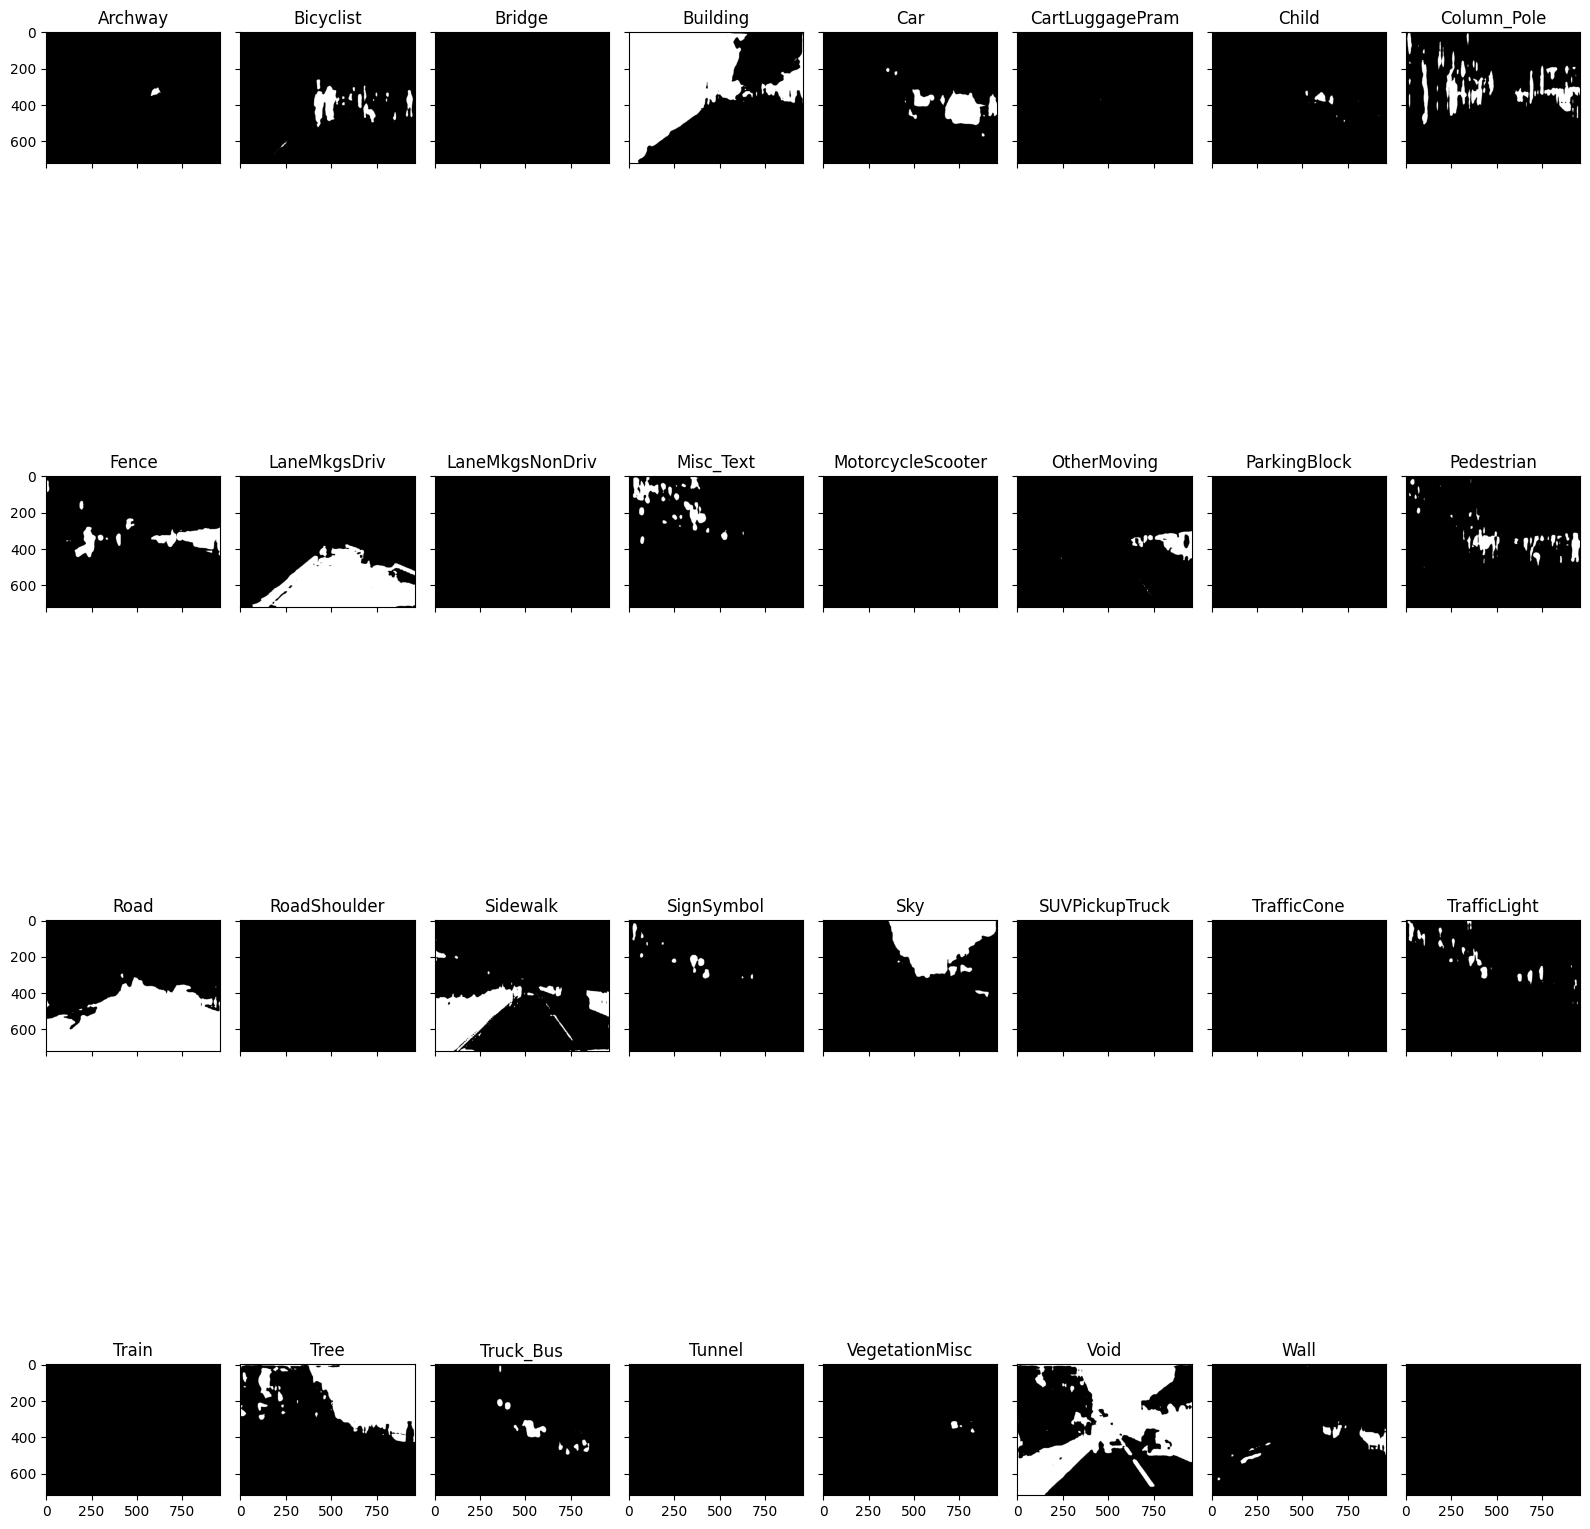

In [36]:
# Create a plot with subplots for each class
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(16,20))
axes_list = [item for sublist in axes for item in sublist]
# Set the threshold for the predicted masks
thresh=0.3
# Get the predicted masks and plot them
res = image[0].detach().cpu().numpy()
for i, mask in enumerate(res):
    ax = axes_list.pop(0)
    ax.imshow(np.where(mask>thresh, 255, 0), cmap='gray')
    try:
      ax.set_title(list(color_codes.keys())[i])
    except:
      break

# Remove any unused subplots and adjust the layout
for ax in axes_list:
    ax.remove()

plt.tight_layout()